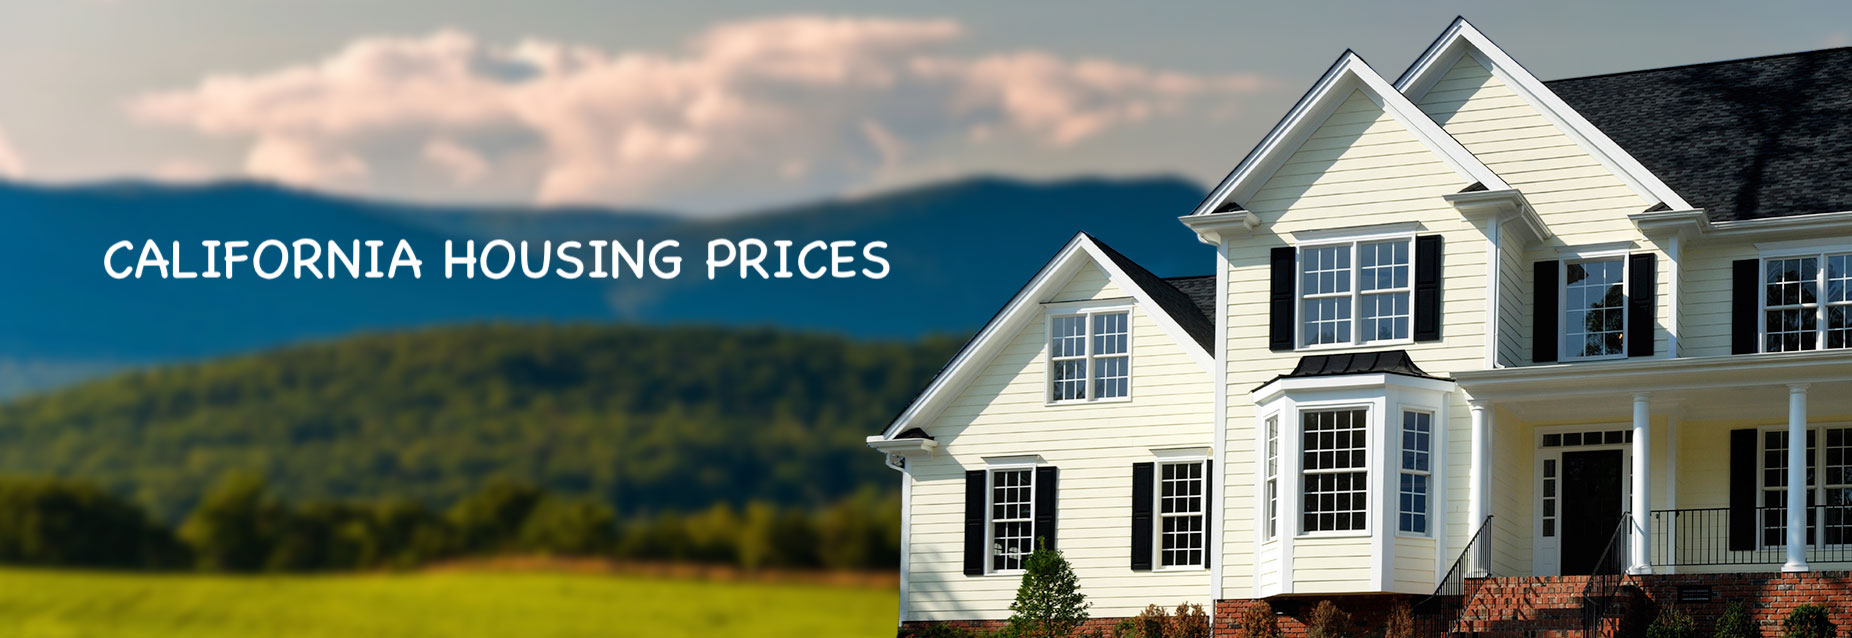

Team Members:   
- Abdulmalik Alrebdi 
- Saad AlOtaibi 
- Shaimaa Alghamdi 
- Sultan Alharbi

# Introduction

In this project we intend on researching housing prices in the state of california based on the data that relates to the houses found in a given California district and some summary stats about them based on the 1990 census data.

Our goal is to create a machine learning model that predicts the price of a given house with as little error as possible.

# Overview of the dataset

The observations of the dataset were described using 10 features as follows:

|Features |Description|
|-----|--------|
|Longitude|A measure of how far west a house is, a higher value is farther west |
|Latitude  |A measure of how far north a house is, a higher value is farther north  |
|housing_median_age  |Median age of a house within a block; a lower number is a newer building    |
|total_rooms  |Total number of rooms within a block     |
|Total_bedrooms  |Total number of bedrooms within a block |
|Population  |Total number of people residing within a block |
|Households  |Total number of households, a group of people residing within a home unit, for a block      |
|median_income  |Median income for households within a block of houses (measured in tens of thousands of US Dollars      |
|ocean_proximity  |Location of the house w.r.t ocean/sea  |
|median_house_value  |Median house value for households within a block (measured in US Dollars)      |



# Code

First we'll import the necessary libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling pre-processing with scikit-learn functionality
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import model_selection

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
# Modeling pre-processing with non-scikit-learn packages
from category_encoders.ordinal import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import compose
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn import linear_model

then we'll import The data

In [10]:
housing = pd.read_csv("../data/housing.csv")

# Preprocessing  
## dealing with mising values

In [11]:
housing.isnull().sum() , housing.shape

(longitude               0
 latitude                0
 housing_median_age      0
 total_rooms             0
 total_bedrooms        207
 population              0
 households              0
 median_income           0
 median_house_value      0
 ocean_proximity         0
 dtype: int64,
 (20640, 10))

there are 207 missing values in the total_bedrooms feature out of 20640 which is only 1%. We chose to fill those null values with the mean of all the total_bedrooms in the dataset.

In [12]:
bedrooms_mean = float(int(housing["total_bedrooms"].mean()))
housing["total_bedrooms"].fillna(bedrooms_mean, inplace = True)

# Exploratory Data Analysis (EDA)

First let's take a look at the distribution of all the features.

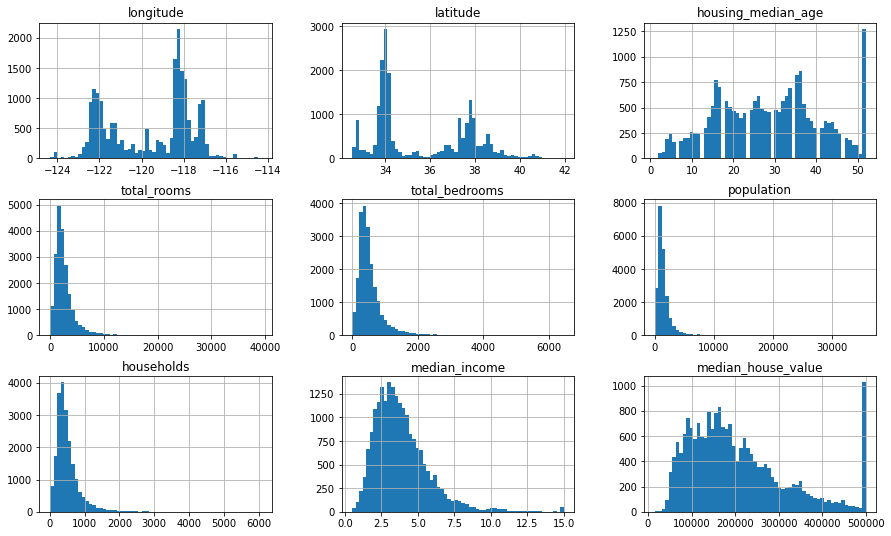

In [13]:
housing.hist(bins=60, figsize=(15,9));plt.show()

We notice that some of these features are right-side skewed so we should deal with that in the Feature engineering

let's discover is the price related to the location?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


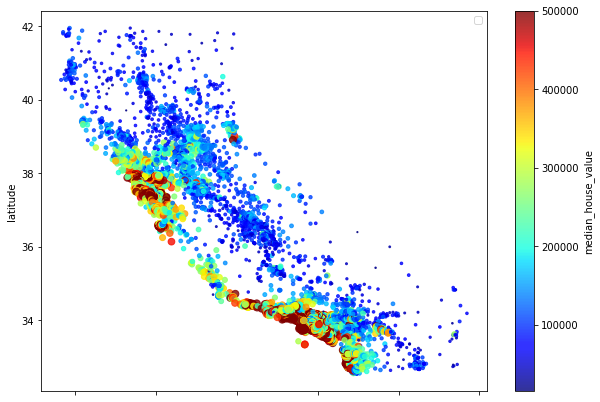

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.8,
s=housing["median_house_value"]/10000, figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

The locations of houses near the ocean are considered the highest price.


What is the most common place to live?


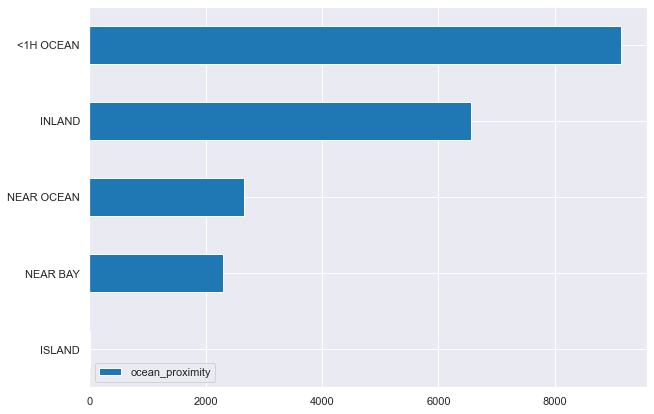

In [15]:
sns.set(palette='tab10')
housing.ocean_proximity.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(10,7))
plt.legend()

Most of the houses in our dataset are 1 hour or more away from the ocean

# Feature Engineering

### separate features from labels and only use numeric features


In [16]:
train, test = train_test_split(housing, train_size=0.7, random_state=123)
X_train = train.drop("median_house_value", axis=1)
y_train = train[["median_house_value"]]

### Filter out zero or near-zero variance features.

first we have to remove all unique values and those any feature that has varince less than 10% becouse they might affect our model  

In [17]:
nzv = VarianceThreshold(threshold=0.1)

for the imputation we already delt with that in the prepossing phase 

### Normalize and Standardize the features

since there are negative values we will use  yeo-johnson model insted of cox-Box 

In [18]:
X_norm = ColumnTransformer([("norm",  PowerTransformer(method = "yeo-johnson"), selector(dtype_include="number"))])
scaler = StandardScaler()

since our dataset is relatively small, we have only 10 columns so we don't need  Perform dimension reduction (PCA)

### One-hot or dummy encode categorical features.

we have only one column that is categorical whitch is ocean_proximity so we need to impelemnt one-hot  or  dummy encoding any will work fine so we chose one hot encoding

In [19]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# apply to all categorical features
dummy_encoder = ColumnTransformer([("dummy", encoder, selector(dtype_include="object"))])

### Putting the process together 

In [20]:
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv, selector(dtype_include="number")),

  ("std_encode", scaler, selector(dtype_include="number")),
 
  ("one-hot", encoder, selector(dtype_include="object")),
  ])

# Modeling

First we'll implement a simple Linear Regression Model

### Linear Regression

In [21]:
# Create an instance of the model
lm_mod = linear_model.LinearRegression()


In [22]:
# We'll pipeline it with the feature engineering that we did earlier
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
   ("lm", lm_mod),
])

In [71]:
# Create a 10 fold cross validataion object and define the loss function which is the RSME
kfold = KFold(n_splits=5, random_state=123, shuffle=True)
loss = 'neg_root_mean_squared_error'

In [72]:
# Cross Validation
cv_results = model_selection.cross_val_score(
  estimator=model_pipeline, # pipeline above 
  X=X_train, # training set 
  y=y_train, # target training set  
  cv=kfold, #number of folds cross validation 
  scoring=loss
  )
  
cv_results

array([-67395.92789312, -70583.62831182, -69067.48725691, -68941.03808327,
       -68753.04138186])

In [73]:
results = np.absolute(cv_results.mean()) 
results

68948.2245853947

The RMSE for our Linear Regressor model is 68948.2245853947, We'll try to do better with the next model.

### Random Forest